# Section: Algorithm Using Value-Based Placement

## This section provides a short explanation of the code of the algorithm
## The graphs were displayed to provide context for the alternative generation methods
## This algorithm generates the instrument panel according to a value-based system on the attribute called "Procedural Use"
## "Procedural Use" is dictated by the number of instruments that must be used in a given procedure

In [1]:
import sklearn as skl
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import math
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import janitor
import cairo
import random
import re
import collections
import networkx as nx
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from collections import namedtuple
from random import randint
## Cleaning imports
import hashlib
import os
import imageio
from imageio import imread
from hashlib import md5

The following statements regard the output display in Jupyter and custom named Tuples. The tuples are named "Point" to represent each co-ordinate on the canvas.

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
Point = collections.namedtuple('Point', 'x y')

It is very important that any new instrument added is included in each sheet found in the excel file. The format should be as the provided instruments.

In [4]:
df = pd.read_excel('TestingData.xlsx', sheet_name='QualitySheet')
pf = pd.read_excel('TestingData.xlsx', sheet_name='PhaseSheet')
ss = pd.read_excel('TestingData.xlsx', sheet_name='SizeSpec')
ds = pd.read_excel('TestingData.xlsx', sheet_name='SequenceSheet')
ess = pd.read_excel('TestingData.xlsx', sheet_name='EntireSequenceSheet')

### Network Graphs / Directed and Un-Directed Graphs

getFirst returns the first element of the first procedure so as to begin the graph.

In [5]:
def getFirst(frames):
    iterator = frames[frames == 1].index.values
    if len(iterator) == 0:
        return findIndexUsingNum(frames, 1)
    else:
        return iterator[0]

getSize returns the size of the procedure

In [6]:
def getSize(frame):
    size = frame.size
    for f in frame:
        if(type(f) == np.str):
            for c in f:
                if(c == ','):
                    size+=1
    return size

In [7]:
def findIndexUsingNum(frames, number):
    for frame in frames:
        if(type(frame) == np.str):
            nums = re.findall('\d+', frame)
            nums = list(map(int, nums))
            if number in nums:
                 return frames[frames == frame].index.values[0]
    return None

dropProdCol is a function built to check if the column "Procedures" is still in the dataframe and removes it if so. The column serves no purpose for the creation of network graphs.

In [8]:
## Drop column from ds
def dropProdCol(dataframe):
    if 'Procedures' in dataframe.columns:
        dataframe = dataframe.drop(columns=['Procedures'])
        return dataframe
    else:
        return dataframe

In [9]:
# Remove the "Quality" Column as it serves no purpose in data
# Remove the row "Procedural Use"
def graphTransformation(df):
    totals = []
    df = df[df.Quality != 'Procedural Use']
    for col in df.columns.values:
        if(col != 'Quality'):
            totals.append(sum(df[col]))
    transformationGraph = pd.DataFrame(columns=df.columns)
    transformationGraph = transformationGraph.drop(columns=['Quality'])
    ## New list of names
    newNameList = []
    for colName in transformationGraph.columns.values:
        newNameList.append(colName+'_OutputNode')
    transformationGraph.columns = newNameList
    tot = pd.Series(totals, index=transformationGraph.columns)
    transformationGraph = transformationGraph.append(tot, ignore_index=True)
    return transformationGraph

In [10]:
# Use only for interconnected procedures
def entireGraph_Directed_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_OutputNode', weight=transDataFrame.iloc[0][col+'_OutputNode'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0']
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_OutputNode', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_OutputNode', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

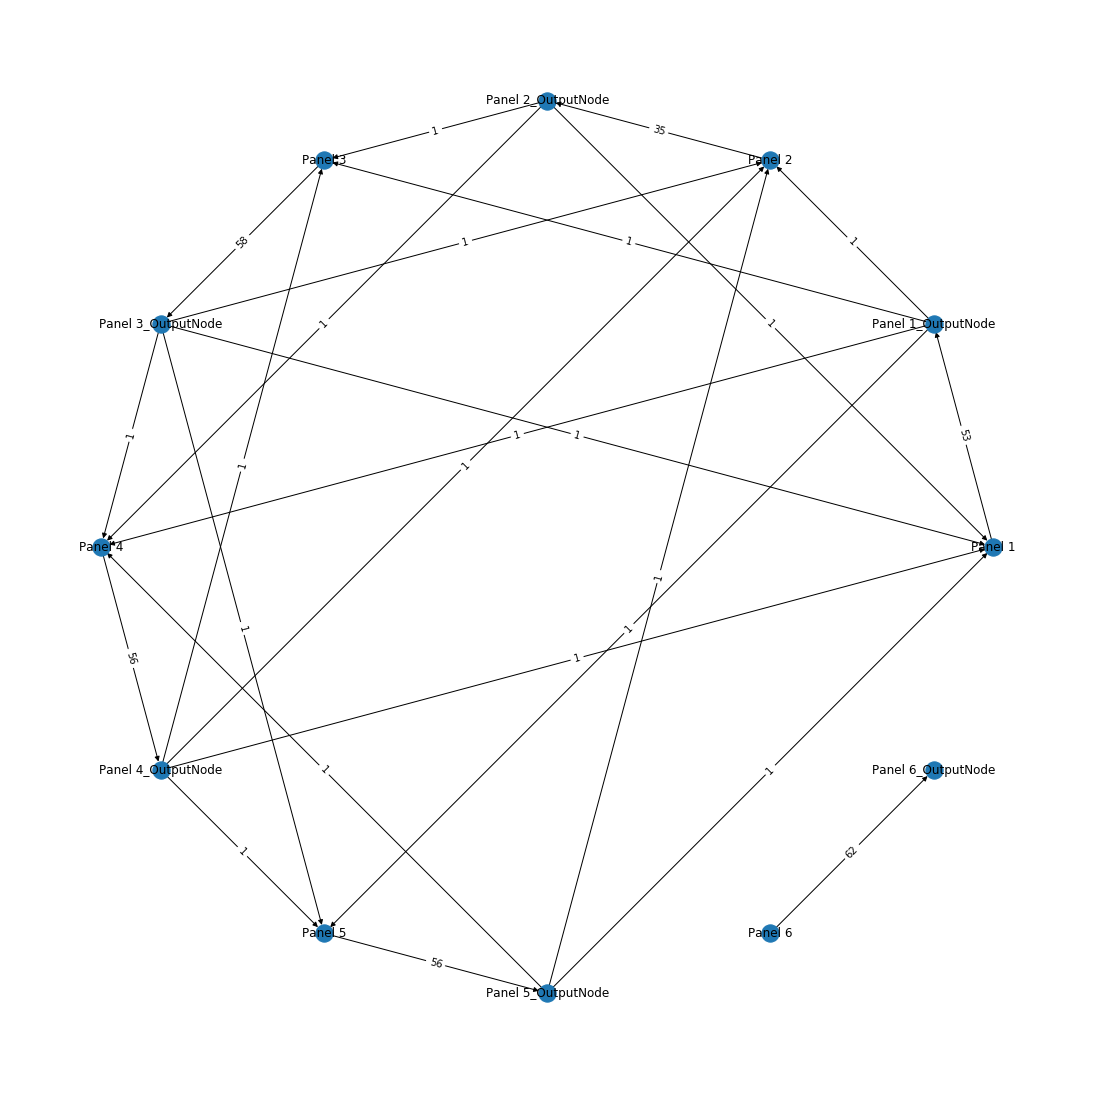

In [11]:
## Draw the entire graph with the procedures interconnected
## Directed
ess = dropProdCol(ess)
fullGraph_Directed_withWeights = entireGraph_Directed_withWeights(ess, df)

In [12]:
# Use only for sequence only
def drawFullDetailedDirectedGraphs_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_OutputNode', weight=transDataFrame.iloc[0][col+'_OutputNode'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        ## This occurs twice because the values were switched to text         
        frames = frames[frames != 0]         
        frames = frames[frames != '0'] 
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_OutputNode', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_OutputNode', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

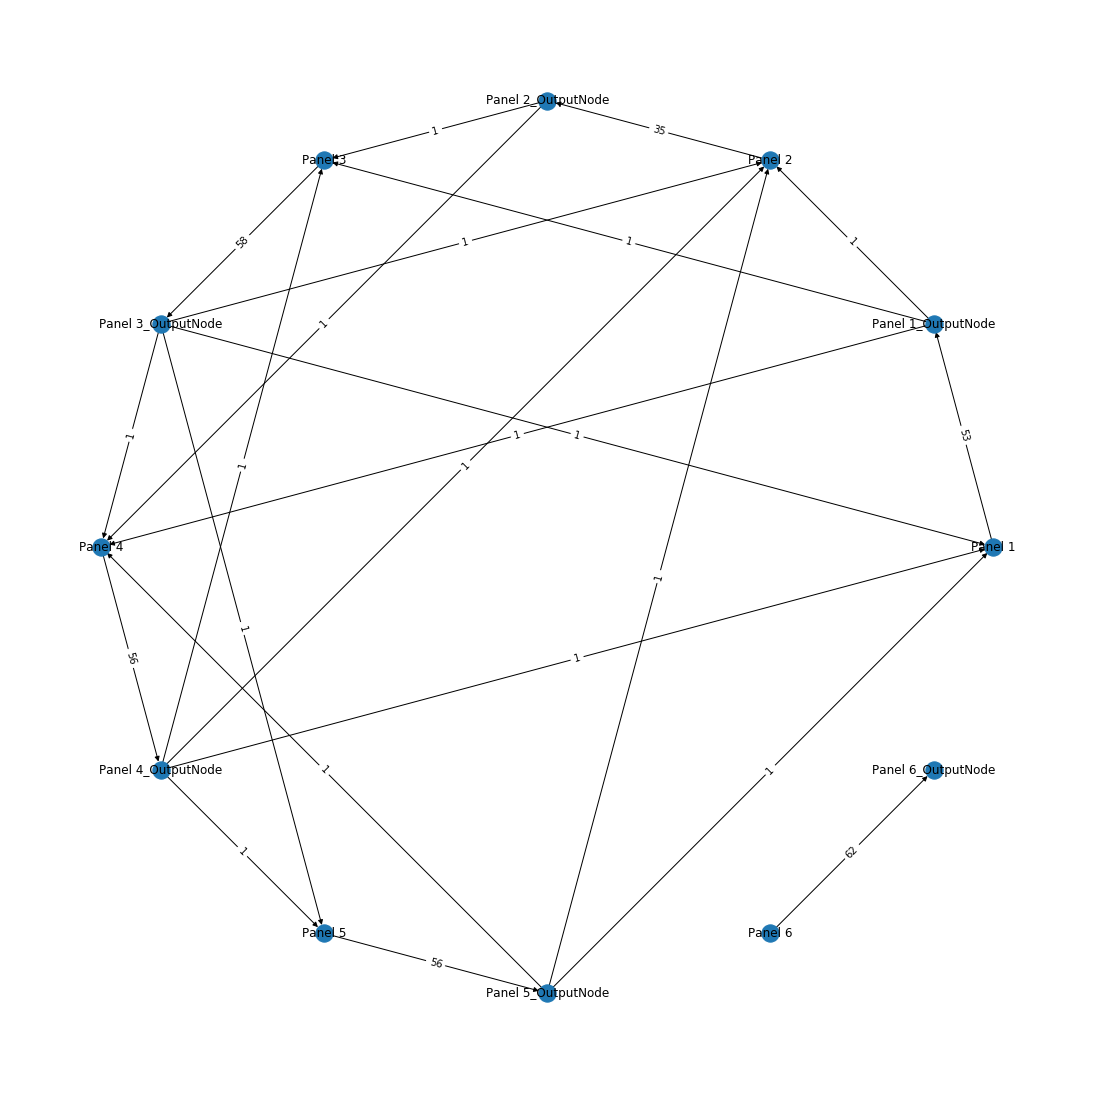

In [13]:
## Drawing full directed graph with weights- one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
procedureOnly_DirectedGraph_Full_Weighted = drawFullDetailedDirectedGraphs_withWeights(ds, df)

The value '2' is the identifer of the exit node of an instrument. For example CPU is the input and CPU2 is the output.
What this algorithm does is that it creates the list in the correct traversal order, but it removes all mention of the exit nodes.

In [14]:
def getCleanList_Tuple(dirtyTupleList):
    cleanList = []
    for item in dirtyTupleList:
        (val1, val2) = item
        if "_OutputNode" not in val1 and val1 not in cleanList:
            cleanList.append(val1)
        if "_OutputNode" not in val2 and val2 not in cleanList:
            cleanList.append(val2)
    return cleanList

The purpose of this function is to find the very first node of the graph, the starting node.
This will ensure that regardless of the traversal algorithm used, both algorithms start from the same point.

In [15]:
def getFirstAsSource(dataFrame):
    answer = dataFrame.iloc[0]
    ans = answer[answer == 1].index[0]
    return ans

The following four algorithms retreive the edge nodes from the graphs using their respective traversal algorithms of Breadth first search and depth first search.
It is important for all nodes to be 'cleaned' afterwards, removing the exit nodes labelled with '\_OutputNode' in order to only list instruments.

In [16]:
## Depth First search on procedural only, directed graph, full
dfs_tree_procedureOnly_DirectedGraph_Full_Weighted = nx.dfs_edges(procedureOnly_DirectedGraph_Full_Weighted, source=getFirstAsSource(ess))
clean_dfs_list_procedureOnly_DirectedGraph_Full_Weighted = getCleanList_Tuple(list(dfs_tree_procedureOnly_DirectedGraph_Full_Weighted))

In [17]:
## Breadth First search on procedural only, directed graph, full
bfs_tree_procedureOnly_DirectedGraph_Full_Weighted = nx.bfs_edges(procedureOnly_DirectedGraph_Full_Weighted, source=getFirstAsSource(ess))
clean_bfs_list_procedureOnly_DirectedGraph_Full_Weighted = getCleanList_Tuple(list(bfs_tree_procedureOnly_DirectedGraph_Full_Weighted))

In [18]:
## Depth First search on start to finish, directed graph, full
dfs_tree_fullGraph_Directed_withWeights = nx.dfs_edges(fullGraph_Directed_withWeights, source=getFirstAsSource(ess))
clean_dfs_list_fullGraph_Directed_withWeights = getCleanList_Tuple(list(dfs_tree_fullGraph_Directed_withWeights))

In [19]:
## Breadth First search on start to finish, directed graph, full
bfs_tree_fullGraph_Directed_withWeights = nx.dfs_edges(fullGraph_Directed_withWeights, source=getFirstAsSource(ess))
clean_bfs_list_fullGraph_Directed_withWeights = getCleanList_Tuple(list(bfs_tree_fullGraph_Directed_withWeights))

### Algorithm: Based on generating instrumentation in a cluster
#### This algorithm is based on a value-based system, ordered by the attribute "Procedural Use"
#### The algorithm is then adapted to use graph traversal algorithms Breadth and Depth First Search
##### Generation with this algorithm is based on random sides from which to grow.

In [20]:
## Creating pandas dataframe: 1 row for each instrument with the following parameters;
# Name,TotalAttributes,ProceduralUse,Height,Width
# 4 columns added later for points AboveRight,AboveLeft,UnderRight,UnderLeft
def dataFrameCreation(pd, df):
    instFrame = pd.DataFrame(columns=['Name', 'TotalAttributes',
                                      'ProceduralUse', 'Height',
                                      'Width', 'AboveRight',
                                      'AboveLeft','UnderRight',
                                      'UnderLeft', 'Colour'])
    columnList = df.columns.values.tolist()
    columnList.remove('Quality')
    for inst in columnList:
        instFrame = instFrame.append({'Name': inst, 'TotalAttributes': df[inst].sum(),
                                      'ProceduralUse': pf[inst].sum(),
                                      'Height':ss.loc[ss.Instrument == inst]['Height'].values[0],
                                      'Width' :ss.loc[ss.Instrument == inst]['Width'].values[0],
                                     'AboveRight': 0,
                                     'AboveLeft': 0,
                                     'UnderRight': 0,
                                     'UnderLeft': 0},
                                     ignore_index=True)

    return instFrame

colGen and colPick are methods accessed by the drawing algorithm to select a unique colour

In [21]:
## Generate Colours
def colGen():
    ## 100 colours
    colourList = []
    for i in range (100):
        colour = (randint(99,255)/255.0,randint(99,255)/255.0,randint(99,255)/255.0)
        while colour not in colourList:
            colour = (randint(99,255)/255.0,randint(99,255)/255.0,randint(99,255)/255.0)
            colourList.append(colour)
    return colourList

In [22]:
## Colour Picker
def colPick(canvas):
    colourList = canvas.getColList()
    picked = random.choice(colourList)
    colourList.remove(picked)
    canvas.setColList(colourList)
    return picked

The python library called "Cairo" is used in order to generate the panels

In [23]:
## Art Canvas ##
class Canvas:
    
    def __init__(self):
        self.colourList = []
        self.paintWidth = 2000
        self.paintHeight = 2000
        self.ims = cairo.ImageSurface(cairo.FORMAT_ARGB32, self.paintWidth, self.paintHeight)
        self.cr = cairo.Context(self.ims)
    
    def getCanvasWidth(self):
        return self.paintWidth
    
    def getCanvasHeight(self):
        return self.paintHeight
    
    def getCr(self):
        return self.cr
    
    def setColList(self, colList):
        self.colourList = colList
        
    def getColList(self):
        return self.colourList

This algorithm checks that the desired coordinates and the coordinates between them are available and un-used

In [24]:
## Co-ordinate checker
def coChecker(bottomLeft, bottomRight, topLeft, topRight, storage):
    #print("Coordinate checker run")
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            if Point(i, y) in storage.getPointList():
                return True
    return False

The following four algorithms are randomly chosen in order to map out the canvas and determine which coordinates are available for use

In [25]:
## North Check
## precursor variable must be a string
def checkNorth(point, width, height, precursorType, storage):
    #print("Checking North")
    (xAxis, yAxis) = point
    if Point(x=xAxis, y=yAxis-1) in storage.getPointList():
        #print("North is not applicable")
        return None
    else:
        dice = random.getrandbits(1)
        newX = xAxis
        newY = yAxis-1
        if(precursorType == 'AboveRight'):
            #print("Precursor is an AboveRight so our point will be a BelowRight")
            ## This means the starting point will be a BelowRight
            bottomRight = Point(newX, newY)
            bottomLeft = Point(newX-width, newY)
            topRight = Point(newX, newY-height)
            topLeft = Point(newX-width, newY-height)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("North Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("North Precursor fail")
                return None
        elif(precursorType == 'AboveLeft'):
            #print("Precursor is an AboveLeft so our point will be a BelowLeft")
            ## This means the starting point will be a BelowLeft
            bottomRight = Point(newX+width,newY)
            bottomLeft = Point(newX, newY)
            topRight = Point(newX+width, newY-height)
            topLeft = Point(newX, newY-height)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("North Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("North Precursor fail")
                return None
        else:
            print("**************************************Complete fail should not happen")
            return None

In [26]:
## South Check
## precursor variable must be a string
def checkSouth(point, width, height, precursorType, storage):
    #print("Checking South")
    (xAxis, yAxis) = point
    if Point(x=xAxis, y=yAxis+1) in storage.getPointList():
        #print("South is not applicable")
        return None
    else:
        newX = xAxis
        newY = yAxis+1
        if(precursorType == 'UnderLeft'):
            #print("Precursor is an UnderLeft so our point will be a AboveLeft")
            ## This means the starting point will be a AboveLeft
            bottomRight = Point(newX+width, newY+height)
            bottomLeft = Point(newX, newY+height)
            topRight = Point(newX+width, newY)
            topLeft = Point(newX, newY)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("South Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("South Precursor fail") 
                return None
        elif(precursorType == 'UnderRight'):
            #print("Precursor is an UnderRight so our point will be a AboveRight")
            ## This means the starting point will be a AboveRight
            bottomRight = Point(newX, newY+height)
            bottomLeft = Point(newX-width, newY+height)
            topRight = Point(newX, newY)
            topLeft = Point(newX-width, newY)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("South Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("South Precursor fail") 
                return None
        else:
            print("**************************************Complete fail should not happen")
            return None

In [27]:
## West Check
## precursor variable must be a string
def checkWest(point, width, height, precursorType, storage):
    #print("Checking East")
    (xAxis, yAxis) = point
    if Point(x=xAxis-1, y=yAxis) in storage.getPointList():
        #print("West is not applicable")
        return None
    else:
        newX = xAxis-1
        newY = yAxis
        if(precursorType == 'UnderLeft'):
            #print("Precursor is an UnderLeft so our point will be a BottomRight")
            ## This means the starting point will be a BottomRight
            bottomRight = Point(newX, newY)
            bottomLeft = Point(newX-width, newY)
            topRight = Point(newX, newY-height)
            topLeft = Point(newX-width, newY-height)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("West Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("West Precursor fail") 
                return None
        elif(precursorType == 'AboveLeft'):
            #print("Precursor is an AboveLeft so our point will be a AboveRight")
            ## This means the starting point will be a AboveRight
            bottomRight = Point(newX, newY+height)
            bottomLeft = Point(newX-width, newY+height)
            topRight = Point(newX, newY)
            topLeft = Point(newX-width, newY)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("West Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("West Precursor fail") 
                return None
        else:
            print("**************************************Complete fail should not happen")
            return None

In [28]:
## East Check
## precursor variable must be a string
def checkEast(point, width, height, precursorType, storage):
    #print("Checking West")
    (xAxis, yAxis) = point
    if Point(x=xAxis+1, y=yAxis) in storage.getPointList():
        #print("East is not applicable")
        return None
    else:
        newX = xAxis+1
        newY = yAxis
        if(precursorType == 'AboveRight'):
            #print("Precursor is an aboveRight so our point will be a AboveLeft")
            ## This means the starting point will be a AboveLeft
            bottomRight = Point(newX+width, newY+height)
            bottomLeft = Point(newX, newY+height)
            topRight = Point(newX+width, newY)
            topLeft = Point(newX, newY)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("East Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("East Precursor fail") 
                return None
        elif(precursorType == 'UnderRight'):
            #print("Precursor is an UnderRight so our point will be a BottomLeft")
            ## This means the starting point will be a BottomLeft
            bottomRight = Point(newX+width,newY)
            bottomLeft = Point(newX, newY)
            topRight = Point(newX+width, newY-height)
            topLeft = Point(newX, newY-height)
            result = coChecker(bottomLeft, bottomRight, topLeft, topRight, storage)
            if result == False:
                #print("East Precursor success")
                return bottomLeft, bottomRight, topLeft, topRight
            else: 
                #print("East Precursor fail") 
                return None
        else:
            print("**************************************Complete fail should not happen")
            return None

pointFinder is tasked with finding the point from which to base of the next instrument to be drawn

In [29]:
def pointFinder(toPlace, alreadyPlaced, storage):
    #print("PointFinder run")
    ## Order is: NSEW
    ## width and height
    width = toPlace['Width'].values[0]
    height = toPlace['Height'].values[0]
    
    ## Pick Point at random
    randomPoint = [0, 1, 2, 3]
    randomDirection = [0, 1]
    random.shuffle(randomPoint)
    
    ## Access each point randomly
    for i in randomPoint:
        if i == 0:
            #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left point of it")
            bottomLeft = alreadyPlaced['UnderLeft'].values[0]
            ## Randomly pick side
            random.shuffle(randomDirection)
            for x in randomDirection:
                if x == 0:
                    ## Check South
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left SOUTH CHECK")
                    result = checkSouth(bottomLeft, width, height, 'UnderLeft', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left SOUTH CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left SOUTH CHECK BAD")
                if x == 1:
                    ## Check West
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left WEST CHECK")
                    result = checkWest(bottomLeft, width, height, 'UnderLeft', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left WEST CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom left WEST CHECK BAD")
        
        if i == 1:
            #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right point of it")
            bottomRight = alreadyPlaced['UnderRight'].values[0]
            ## Randomly pick side
            random.shuffle(randomDirection)
            for x in randomDirection:
                if x == 0:
                    ## Check South
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right SOUTH CHECK")
                    result = checkSouth(bottomRight, width, height, 'UnderRight', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right SOUTH CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right SOUTH CHECK IS BAD")
                if x == 1:
                    ## Check East
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right EAST CHECK")
                    result = checkEast(bottomRight, width, height, 'UnderRight', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right EAST CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " bottom right EAST CHECK IS BAD")
        
        if i == 2:
            #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left point of it")
            topLeft = alreadyPlaced['AboveLeft'].values[0]
            ## Randomly pick side
            random.shuffle(randomDirection)
            for x in randomDirection:
                if x == 0:
                    ## Check North
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left point NORTH CHECK")
                    result = checkNorth(topLeft, width, height, 'AboveLeft', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left NORTH CHECK GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left NORTH CHECK IS BAD")
                if x == 1:
                    ## Check West
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left point WEST CHECK")
                    result = checkWest(topLeft, width, height, 'AboveLeft', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left WEST CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top left WEST CHECK IS BAD")

        if i == 3:
            #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right point of it")
            topRight = alreadyPlaced['AboveRight'].values[0]
            ## Randomly pick side
            random.shuffle(randomDirection)
            for x in randomDirection:
                if x == 0:
                    ## Check North
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right NORTH CHECK")
                    result = checkNorth(topRight, width, height, 'AboveRight', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right NORTH CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right NORTH CHECK IS BAD")
                if x == 1:
                    ## Check East
                    #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right EAST CHECK")
                    result = checkEast(topRight, width, height, 'AboveRight', storage)
                    if result is not None:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right EAST CHECK IS GOOD")
                        return result
                    #else:
                        #print("PointFinder alreadyPlaced ",alreadyPlaced.index.values[0], " top right EAST CHECK IS BAD")
    
    #print("This instrument's sides are all used up ",alreadyPlaced.index.values[0])

findMeAPoint makes use of PointFinder in order to locate the next point from which to draw the next instrument from. findMeAPoint makes the crucial check of ensuing that the first instrument has or has not yet been drawn

In [30]:
# Iterate through the list and perfom the placement checks
def findMeAPoint(instrument, originalFrame, storage):
    ## Find me a point for this instrument
    ## It starts cycling through the existing ones
    for index in originalFrame.index:
        #print("Cycling through all instruments to find a starting point. Current: ", index)
        tempFrame = originalFrame.loc[[index]]
        if(tempFrame['AboveRight'].values[0] == 0 and tempFrame['AboveLeft'].values[0] == 0 and 
           tempFrame['UnderRight'].values[0] == 0 and tempFrame['UnderLeft'].values[0] == 0):
            #print("This is all nulls, so it must be the first: ", index)
            #firstToPlace(instrument , originalFrame)
            return
        else:
            ## Check each point and if valid, check direction
            #print("This is not the first instrument, must find point from: ", index, " for ", instrument.index.values[0])
            result = pointFinder(instrument,tempFrame, storage)
            if result is not None:
                return result
            #print("THE FOR LOOP FOR FIND ME A POINT GOES ON")
    print("*********************************************************POINT NOT FOUND == SHOULD NOT OCCUR")

drawThis passes the index number, meaning the data of the instrument which is tasked to be drawn

In [31]:
# Instrument and draw it
def drawThis(indexNumber, originalFrame, canvas, storage):
    ## Take width and height
    tempFrame = originalFrame.loc[[indexNumber]]
    ## Call method to find the point which can be used
    result = findMeAPoint(tempFrame, originalFrame, storage)
    if result == None:
        ## it was the first point
        modifiedFrame = artist(tempFrame, None, originalFrame, True, canvas, storage)
        return modifiedFrame
    else:
        modifiedFrame = artist(tempFrame, result, originalFrame, False, canvas, storage)
        return modifiedFrame

The Store class is tasked with the storage of all the coordinates which are used in the drawing

In [32]:
class Store():
       
    def __init__(self):
        self.PointListCovered = set()
    
    def getPointList(self):
        return self.PointListCovered
    
    def setPointList(self, newList):
        self.PointListCovered = newList

pointStorage is a function which stores all the coordinates and those between said coordinates into the store

In [33]:
## Store all points used and save
def pointStorage(bottomLeft, bottomRight, topLeft, topRight, storage):
    PointListCovered = storage.getPointList()
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            PointListCovered.add(Point(i, y))
    storage.setPointList(PointListCovered)

artist makes use of the cairo library in order to draw the instrument panel.
It gets the coordinates and selects the colour which is to be used.

In [34]:
def artist(instrument, toDraw, instFrame, first, canvas, storage):
    #print("CALLED TO DRAW: ", instrument.index.values[0])
    cr = canvas.getCr()
    if first == False:
        (bottomLeft, bottomRight, topLeft, topRight) = toDraw
    elif first == True:
        width = instrument['Width'].values[0]
        height = instrument['Height'].values[0]
        xAxis = math.floor(canvas.getCanvasWidth()/2)
        yAxis = math.floor(canvas.getCanvasHeight()/2)
        topLeft = Point(xAxis,yAxis)
        bottomLeft = Point(xAxis,yAxis+height)
        bottomRight = Point(xAxis+width,yAxis+height)
        topRight = Point(xAxis+width,yAxis)
 
    
    ## Store the coordinates in the pandas dataframe original
    instFrame.at[instrument.index.values[0], 'UnderLeft'] = bottomLeft
    instFrame.at[instrument.index.values[0], 'UnderRight'] = bottomRight
    instFrame.at[instrument.index.values[0], 'AboveLeft'] = topLeft
    instFrame.at[instrument.index.values[0], 'AboveRight'] = topRight
    ## Store the tuples to be covered
    pointStorage(bottomLeft, bottomRight, topLeft, topRight, storage)
    ## Now to draw
    (x1,y1) = bottomLeft
    (x2,y2) = bottomRight
    (x3,y3) = topLeft
    (x4,y4) = topRight
    
    cr.move_to(x1,y1)
    cr.line_to(x2,y2)
    cr.line_to(x4,y4)
    cr.line_to(x3,y3)
    cr.line_to(x1,y1)
    cr.close_path()
    
    if instrument['Colour'].isnull().values:
        (r,g,b) = colPick(canvas)
        instFrame.at[instrument.index.values[0], 'Colour'] = (r,g,b)
    else:
        (r,g,b) = instrument['Colour'].values[0]
    cr.set_source_rgb(r,g,b)
    cr.fill_preserve()
    cr.stroke()
    return instFrame

The task of resetCo is to ensure that the dataFrame coordinates have been reset to 0 so the algorithm can generate a new panel using the same method with random pararmeters.

In [35]:
## Method to reset coordinates for redrawn
def resetCO(instFrame):
    for index in instFrame.index:
        instFrame.at[index, 'UnderLeft'] = 0
        instFrame.at[index, 'UnderRight'] = 0
        instFrame.at[index, 'AboveLeft'] = 0
        instFrame.at[index, 'AboveRight'] = 0
    return instFrame

legendDraw is simply tasked with drawing the legend/key of the instrument panels containing which colours are assigned to what instrument.

In [36]:
## Legend Artist
def legendDraw(instFrame):
    ## Create canvas
    ims = cairo.ImageSurface(cairo.FORMAT_ARGB32, 2000, 2000)
    cr = cairo.Context(ims)
    x1 = 1000
    y1 = 500
    x2 = 1200
    x3 = 1250
    for index in instFrame.index:
        tempFrame = instFrame.loc[[index]]
        print(tempFrame)
        (r,g,b) = tempFrame['Colour'].values[0]
        cr.set_source_rgb(r,g,b)
        cr.move_to(x1,y1)
        cr.line_to(x2,y1)
        cr.set_line_width(19)
        cr.stroke()
        cr.move_to(x3,y1)
        cr.set_source_rgb(0, 0, 0)
        cr.set_font_size(25)
        cr.select_font_face("Arial",
                     cairo.FONT_SLANT_NORMAL,
                     cairo.FONT_WEIGHT_BOLD)
        print(tempFrame.Name.values[0])
        cr.show_text(tempFrame.Name.values[0])
        y1 = y1 + 100
    ims.write_to_png('ImgResults/Legend.png')

This algorithm uses "Procedural Use" attribute to determine in which order to generate the instrumentation

In [37]:
## Main Method Algorithm ##
instFrame = dataFrameCreation(pd, df)
instFrame = instFrame.sort_values(by=['ProceduralUse'], ascending=False)
for x in range(5):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('ImgResults/Normal_Procedural_'+str(x)+'.png')
legendDraw(instFrame)

      Name TotalAttributes ProceduralUse Height Width    AboveRight  \
2  Panel 3              63            21     25   146  (1146, 1000)   

      AboveLeft    UnderRight     UnderLeft  \
2  (1000, 1000)  (1146, 1025)  (1000, 1025)   

                                              Colour  
2  (0.5882352941176471, 0.4196078431372549, 0.498...  
Panel 3
      Name TotalAttributes ProceduralUse Height Width   AboveRight  \
1  Panel 2              36            17    210   213  (999, 1000)   

     AboveLeft   UnderRight    UnderLeft  \
1  (786, 1000)  (999, 1210)  (786, 1210)   

                                              Colour  
1  (0.7058823529411765, 0.9607843137254902, 0.807...  
Panel 2
      Name TotalAttributes ProceduralUse Height Width   AboveRight  \
3  Panel 4              60            14    152   146  (1146, 847)   

     AboveLeft   UnderRight    UnderLeft  \
3  (1000, 847)  (1146, 999)  (1000, 999)   

                                              Colour  
3  (0.61176

This algorithm uses Breadth first search on a graph which plots with accordance to the procedures only

In [38]:
## Sorted - full directed graph from procedure only BFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_bfs_list_procedureOnly_DirectedGraph_Full_Weighted)
instFrame = instFrame.sort_values('Name')
for x in range(100):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('ImgResults/Procedural_Full_Weighted_BFS_'+str(x)+'.png')
legendDraw(instFrame)

      Name TotalAttributes ProceduralUse Height Width    AboveRight  \
2  Panel 3              63            21     25   146  (1146, 1000)   

      AboveLeft    UnderRight     UnderLeft  \
2  (1000, 1000)  (1146, 1025)  (1000, 1025)   

                                              Colour  
2  (0.5882352941176471, 0.4196078431372549, 0.498...  
Panel 3
      Name TotalAttributes ProceduralUse Height Width   AboveRight  \
4  Panel 5              57             7    228   146  (1146, 771)   

     AboveLeft   UnderRight    UnderLeft  \
4  (1000, 771)  (1146, 999)  (1000, 999)   

                                            Colour  
4  (0.39215686274509803, 0.6, 0.49019607843137253)  
Panel 5
      Name TotalAttributes ProceduralUse Height Width   AboveRight  \
3  Panel 4              60            14    152   146  (999, 1000)   

     AboveLeft   UnderRight    UnderLeft  \
3  (853, 1000)  (999, 1152)  (853, 1152)   

                                              Colour  
3  (0.611764705

TypeError: Context.show_text() argument 1 must be str, not float

This algorithm uses depth first search on a graph which plots with accordance to the procedures only

In [ ]:
## Sorted - full directed graph from procedure only DFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_dfs_list_procedureOnly_DirectedGraph_Full_Weighted)
instFrame = instFrame.sort_values('Name')
for x in range(100):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('ImgResults/Procedural_Weighted_DFS_'+str(x)+'.png')
legendDraw(instFrame)

This algorithm uses breath first search on a graph which plots with from the first instrument used in the first procedure, straight to the last instrument used in the last procedure.

In [ ]:
## Sorted - full directed graph from start to finish BFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_bfs_list_fullGraph_Directed_withWeights)
instFrame = instFrame.sort_values('Name')
for x in range(100):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('ImgResults/SF_Full_Weighted_BFS_'+str(x)+'.png')
legendDraw(instFrame)

This algorithm uses breath first search on a graph which plots with from the first instrument used in the first procedure, straight to the last instrument used in the last procedure.

In [ ]:
## Sorted - full directed graph from start to finish DFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_dfs_list_fullGraph_Directed_withWeights)
instFrame = instFrame.sort_values('Name')
for x in range(100):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = drawThis(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('ImgResults/SF_Full_Weighted_DFS_'+str(x)+'.png')
legendDraw(instFrame)

#### Cleaning the duplicate images using hashing

In [ ]:
files_list = os.listdir()
duplicates = []
hash_keys = dict()
for index, filename in enumerate(os.listdir('./ImgResults/')): # . means current directory
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))

In [ ]:
## Display Duplicates
for file_indexes in duplicates[:]:
    try:
    
        plt.subplot(121),plt.imshow(imread(files_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread(files_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    except OSError as e:
        continue

In [ ]:
# Delete all duplicates save for one
for index in duplicates:
    os.remove(files_list[index[0]])